# Import Libralies

In [8]:
# Data Manipulation
import pandas as pd

# Math thing
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# K-mean Algorithm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

## Read the data file

In [2]:
def read_datafile(filepath):
    """reads the data file and pastes into a data frame."""
    df = pd.read_csv(filepath)
    return df

filepath = 'Wholesale customers data.csv'
df = read_datafile(filepath)

df.sample(7)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
296,1,2,19087,1304,3643,3045,710,898
307,1,2,17327,2374,2842,1149,351,925
122,1,3,12212,201,245,1991,25,860
318,1,2,11800,2713,3558,2121,706,51
52,2,3,40721,3916,5876,532,2587,1278
15,1,3,10253,1114,3821,397,964,412
153,1,3,3463,9250,2368,779,302,1627


## Get overview of the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [4]:
df.shape

(440, 8)

In [5]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [6]:
df.duplicated().sum()

0

## Data Exploratory Analysis

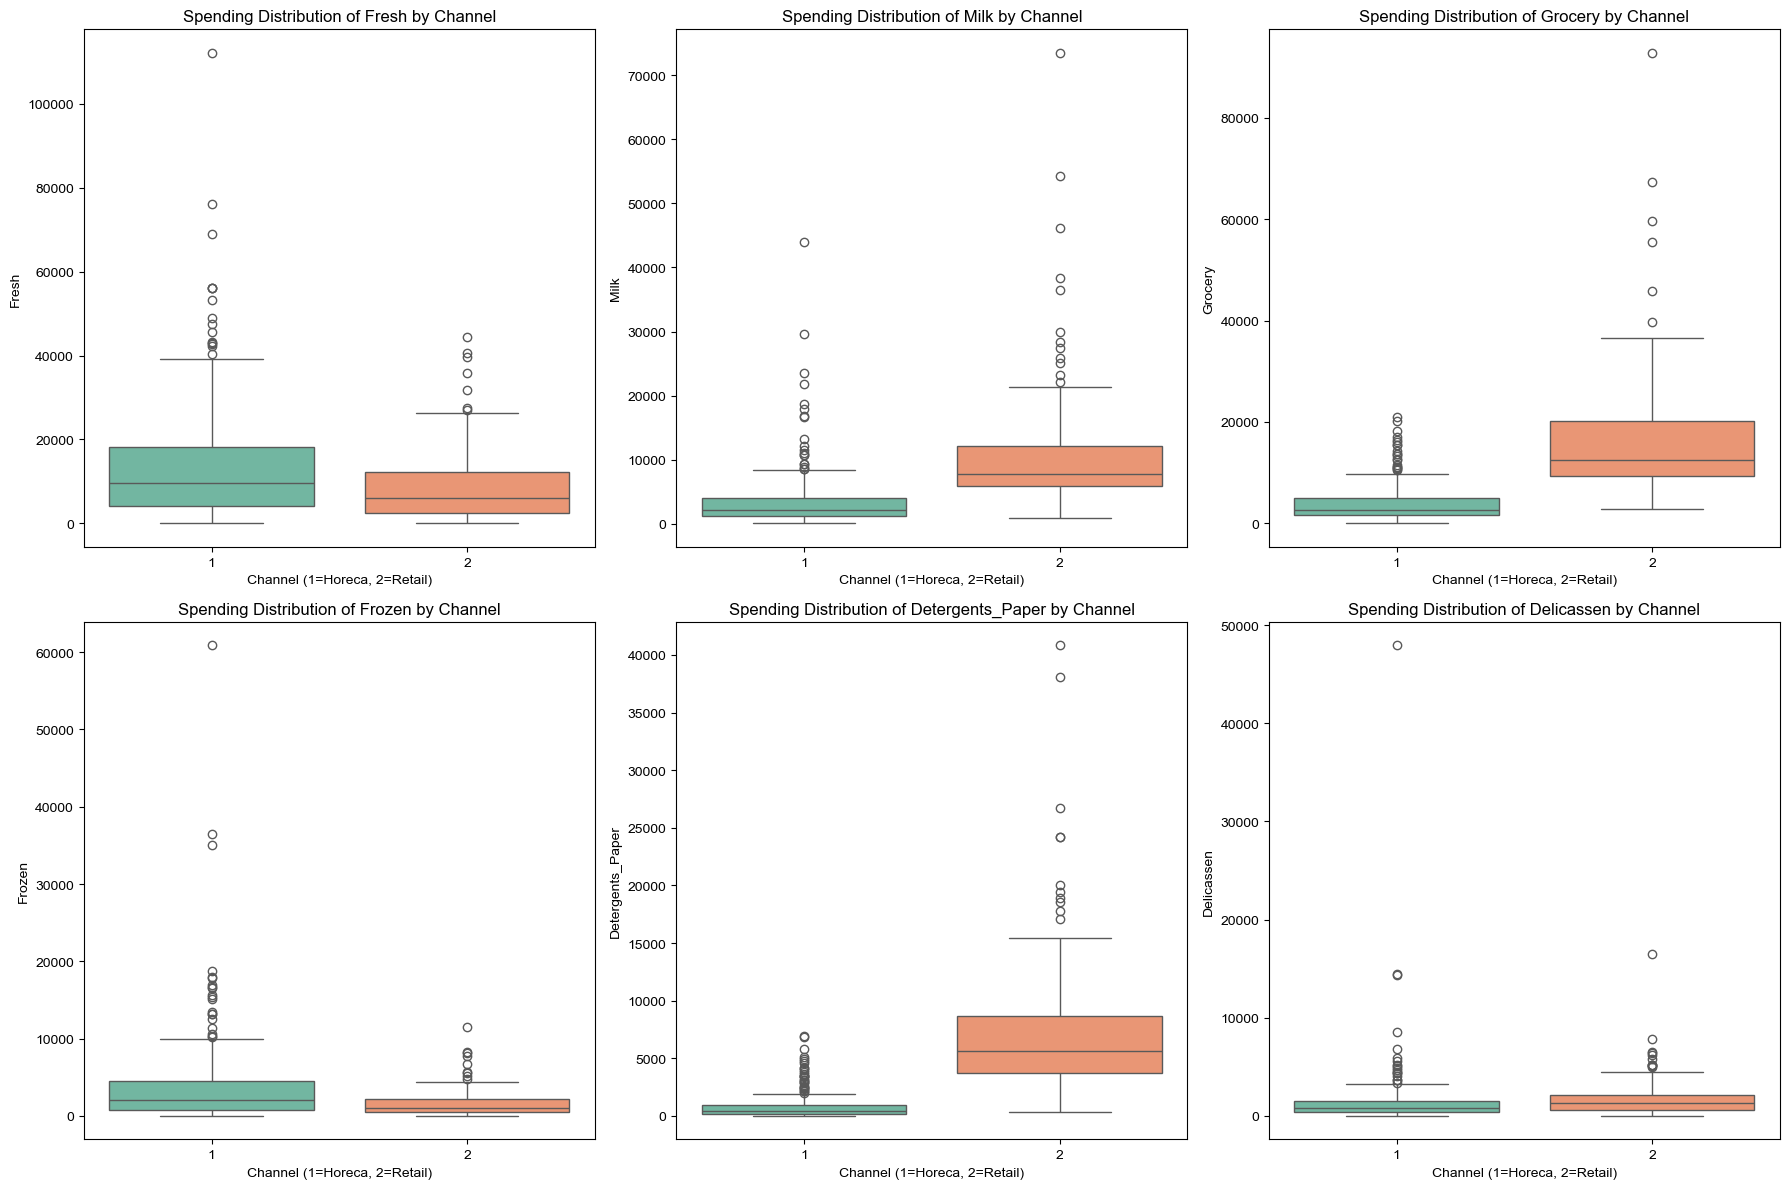

In [7]:
# Create a list of the 6 spending features
spending_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

# Create a figure with a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
plt.style.use('seaborn-v0_8-whitegrid')

# Flatten the axes array for easy iteration (0,0, 0,1, 0,2, 1,0, 1,1, 1,2)
axes = axes.flatten()

# Loop through each spending feature and plot its distribution by Channel
for i, feature in enumerate(spending_features):
    # The corrected line (assigning hue=x and setting legend=False):
    sns.boxplot(x='Channel', y=feature, data=df, ax=axes[i], palette='Set2', hue='Channel', legend=False)
    axes[i].set_title(f'Spending Distribution of {feature} by Channel')
    axes[i].set_xlabel('Channel (1=Horeca, 2=Retail)')

plt.tight_layout()
plt.show()

## Data Preparation

In [ ]:
# Log Transformation

# Apply log transformation to all 6 spending columns
spending_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

# We add 1 before taking the log (log(x+1)) to handle any potential zero values
# (though zero is unlikely for annual spending, it's good practice)
df_log = df.copy()
df_log[spending_features] = np.log1p(df_log[spending_features])

# The clustering analysis will be performed on df_log

In [10]:
# Standard Scaling

# 1. Categorical Encoding (One-Hot Encoding)
# We convert 'Channel' and 'Region' into binary columns (dummies)
df_encoded = pd.get_dummies(df_log, columns=['Channel', 'Region'], drop_first=False)

# 2. Separate Features for Scaling
# We want to scale ALL features (log-transformed spending + encoded categories)
X_data = df_encoded.drop(columns=['Channel_1', 'Region_1'], errors='ignore') # Drop one column from each group if using drop_first=True

# Note: If you used drop_first=False above (as shown in the code), you keep all columns
# For clustering, keeping all dummy columns is often fine, but let's select ALL for safety:
X_features = df_encoded.columns

# 3. Apply Standard Scaling
scaler = StandardScaler()

# Fit and transform the data
X_scaled_array = scaler.fit_transform(df_encoded[X_features])

# Convert the array back to a DataFrame for easier handling in the next steps (PCA)
X_scaled = pd.DataFrame(X_scaled_array, columns=X_features)

print("Shape of the scaled data (X_scaled):", X_scaled.shape)
print("\nFirst 5 rows of the scaled data:")
print(X_scaled.head())

Shape of the scaled data (X_scaled): (440, 11)

First 5 rows of the scaled data:
      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen  \
0  0.486184  0.976299  0.440155 -1.509250          0.644143    0.408966   
1  0.087889  0.990956  0.652171  0.134052          0.766043    0.627926   
2  0.016356  0.891151  0.454687  0.376899          0.804405    1.776833   
3  0.517477 -0.957973 -0.084792  1.141574         -0.328712    0.633133   
4  0.880631  0.439662  0.395847  0.757322          0.404939    1.456588   

   Channel_1  Channel_2  Region_1  Region_2  Region_3  
0  -1.448652   1.448652 -0.460566 -0.345822  0.626422  
1  -1.448652   1.448652 -0.460566 -0.345822  0.626422  
2  -1.448652   1.448652 -0.460566 -0.345822  0.626422  
3   0.690297  -0.690297 -0.460566 -0.345822  0.626422  
4  -1.448652   1.448652 -0.460566 -0.345822  0.626422  
